# Photogrammetry: Part 1
## Inverting the Camera model

You'll recall that back in Project 1, I put a "bonus" problem at the bottom.  The question posed was thus:

A calibrated camera model is a non-linear function that maps from a 3D coordinate system to a 2D coordinate system.  Can this function be inverted?  Can you, based on a 2D image of an object, recover that object's 3D coordinates?  

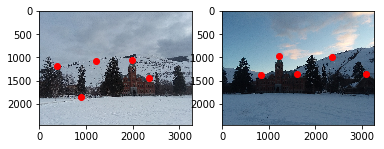

(2448, 3264, 3)
(2448, 3264, 3)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import matplotlib.image as mpimg
import scipy.optimize as so

I_1 = plt.imread('campus_stereo_1.jpg')
I_2 = plt.imread('campus_stereo_2.jpg')

gcp_1 = np.loadtxt('gcp_stereo_1.txt',delimiter=',')
gcp_2 = np.loadtxt('gcp_stereo_2.txt',delimiter=',')

fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(I_1)
axs[0].plot(gcp_1[:,0],gcp_1[:,1],'ro')

axs[1].imshow(I_2)
axs[1].plot(gcp_2[:,0],gcp_2[:,1],'ro')

plt.show()

print (I_1.shape)
print (I_2.shape)
#print(PIL.Image.open('campus_stereo_1.jpg')._getexif())

Calibrating camera models is easy: we have already produced code that allows us to do it.  You'll remember that the solution to this problem is essentially a *non-linear* least squares problem, the solution of which is the optimal camera pose $\mathbf{p}_{opt}$:
$$
\mathbf{p}_{opt} = \mathrm{argmin}_{\mathbf{p}} \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^2 (f(\mathbf{X}_i,\mathbf{p})_j - \mathbf{u}_{ij})^2,
$$
where $n$ is the number of GCPs, and $f(\mathbf{X},\mathbf{p})$ is the projection of real world coordinates $\mathbf{X}$ into camera coordinates (which depends on the pose $\mathbf{p}$, and $\mathbf{u}$ is the pixel coordinates of the equivalent point in the image.

Stated plainly, the objective function above corresponds to the situation in which the real world coordinates of ground control points and their locations in the image are known, while the camera parameters are unknown (and are what we are trying to determine).  What we would like to do is to write an objective function for the converse situation, in which the camera parameters are known, the position of a desired object in an image is known, but the real world coordinates are unknown (and are what we are trying to determine).  Such an objective function might look like this:
$$
\mathbf{X}_{opt} = \mathrm{argmin}_{\mathbf{X}} \frac{1}{2} \sum_{j=1}^2 (f(\mathbf{X},\mathbf{p})_j - \mathbf{u}_j)^2,
$$
where $X_{opt}$ is the position of an object in real world coordinates, $\mathbf{u}$ is its known coordinates in the image, and $\mathbf{p}$ is a known camera model.  Unfortunately, using this objective function is doomed to failure.  Why can't this work?  Counting the number of data points, we find that there are two, the two components of $\mathbf{u}$.  However, the vector $\mathbf{X}$ has three components.  The system is underdetermined: we can only determine $\mathbf{X}$ up to a constant scaling factor.  

How can we make this system of equations over-determined instead?  We can use more cameras, of course.  How does this affect the objective function: 
$$
\mathbf{X}_{opt} = \mathrm{argmin}_{\mathbf{X}} \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^2 (f(\mathbf{X},\mathbf{p}_i)_j - \mathbf{u}_{ij})^2,
$$
where $m$ is the number of cameras, $\mathbf{p}_i$ is the known pose of camera $i$, and $\mathbf{u}_i$ is the location of the feature of interest in the image corresponding to camera $i$.  As in the case of solving for pose, this problem can be solved using Levenburg-Marquardt.  

## Assignment
**In the project file you will find two images (campus_stereo_1.jpg and campus_stereo_2.jpg), with two sets of ground control points (gcp_stereo_1.jpg and gcp_stereo_2.jpg).  Optimze a camera model for each image.  Using both these camera models, implement the optimization problem defined above for determining the [Easting,Northing,Elevation] position of the central pivot on the main hall clock.**

In [16]:
class Camera_pose(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
    def rotational_transform(self,pts,pose):
            """  
            This function performs the translation and rotation from world coordinates into generalized camera coordinates.
            This function takes the Easting, Northing, and Elevation of the features in an image.
            The pose vector is unknown and what we are looking to optimize.
            """
            cam_x = pose[0]
            cam_y = pose[1]
            cam_z = pose[2]
            roll = pose[3]
            pitch = pose[4]
            yaw = pose[5]

            r_axis = np.array([[1, 0, 0], 
                               [0, 0,-1], 
                               [0, 1, 0]])
            r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], 
                               [0, 1, 0], 
                               [np.sin(roll), 0, np.cos(roll)]])            
            r_pitch = np.array([[1, 0, 0], 
                                [0, np.cos(pitch), np.sin(pitch)], 
                                [0, -1*np.sin(pitch), np.cos(pitch)]])           
            r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], 
                              [np.sin(yaw), np.cos(yaw), 0, 0], 
                              [0, 0, 1, 0]])
            T = np.array([[1, 0, 0, -cam_x], 
                          [0, 1, 0, -cam_y], 
                          [0, 0, 1, -cam_z], 
                          [0, 0, 0, 1]])
            C = r_axis @ r_roll @ r_pitch @ r_yaw @ T            
            return C @ pts
               
    def projective_transform(self,rot_pt):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        This function needs the outputs of the rotational transform function (the rotated points).
        """
        focal = self.f 
        sensor = self.c  
        rot_pt = rot_pt.T
        #General Coordinates
        gcx = rot_pt[:,0]/rot_pt[:,2]
        gcy = rot_pt[:,1]/rot_pt[:,2]
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        return np.array([pu,pv]).T
          
    def residual(self, pose, pts, u_gcp):
        ''' Calculate the residual between transformed coordinates on prominant features and measured pixel values of those features'''
        pt = myCam.projective_transform(myCam.rotational_transform(pts,pose))
        res = pt.flatten() - u_gcp.flatten()
        return res    
    def estimate_pose(self, pts, u_gcp):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        p_opt = so.least_squares(self.residual, self.p, method='lm',args=(pts,u_gcp))
        return p_opt

In [17]:
#Estiamte the pose of the two cameras
u_gcp_1 = gcp_1[:,:2] #Pixel Coordinates of ground control points [u,v]
X_gcp_1 = gcp_1[:,2:] #Real World Coordinates of the ground control points [Easting, Northing, Elevation]
X_gcp_1 = (np.c_[X_gcp_1, np.ones(X_gcp_1.shape[0])]).T 

u_gcp_2 = gcp_2[:,:2]
X_gcp_2 = gcp_2[:,2:]
X_gcp_2 = (np.c_[X_gcp_2, np.ones(X_gcp_2.shape[0])]).T 

# Initial guess at pose
roll_init = np.radians(0.0)
pitch_init = np.radians(0.0)
yaw_init = np.radians(90.0)
pose_0 = np.array([2.725e5, 5.1939e6, 1100., roll_init, pitch_init, yaw_init])

# Initialize camera object
myCam = Camera_pose()
myCam.f = (27/36.)*3264. # Focal length
myCam.c = np.array([2448.,3264.]) # Sensor size
myCam.p = pose_0

# Estimate Pose
pose_cam1 = myCam.estimate_pose(X_gcp_1, u_gcp_1).x
pose_cam2 = myCam.estimate_pose(X_gcp_2, u_gcp_2).x
#print (pose_cam1)
#print (pose_cam2)

In [18]:
class Object_Position(object):
    def __init__(self):
        #self.p1 = None                  # Pose cam 1
        #self.p2 = None                  # Pose cam2
        self.pts = None                 # Real world coordinates-that we are optimizing
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
                
    def rotational_transform(self,pts,pose):
            """  
            This function performs the translation and rotation from world coordinates into generalized camera coordinates.
            This function takes the Easting, Northing, and Elevation of the features in an image.
            The pose vector is unknown and what we are looking to optimize.
            """
            cam_x = pose[0]
            cam_y = pose[1]
            cam_z = pose[2]
            roll = pose[3]
            pitch = pose[4]
            yaw = pose[5]

            r_axis = np.array([[1, 0, 0], 
                               [0, 0,-1], 
                               [0, 1, 0]])
            r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], 
                               [0, 1, 0], 
                               [np.sin(roll), 0, np.cos(roll)]])
            r_pitch = np.array([[1, 0, 0], 
                                [0, np.cos(pitch), np.sin(pitch)], 
                                [0, -1*np.sin(pitch), np.cos(pitch)]])
            r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], 
                              [np.sin(yaw), np.cos(yaw), 0, 0], 
                              [0, 0, 1, 0]])
            T = np.array([[1, 0, 0, -cam_x], 
                          [0, 1, 0, -cam_y], 
                          [0, 0, 1, -cam_z], 
                          [0, 0, 0, 1]])
            C = r_axis @ r_roll @ r_pitch @ r_yaw @ T

            pts = np.append(pts, 1)[:,np.newaxis]
            
            return C @ pts
                
    def projective_transform(self,rot_pt):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        This function needs the outputs of the rotational transform function (the rotated points).
        """
        focal = self.f 
        sensor = self.c 
        rot_pt = rot_pt.T
        
        #General Coordinates
        gcx = rot_pt[:,0]/rot_pt[:,2]
        gcy = rot_pt[:,1]/rot_pt[:,2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv]).T
          
    def residual(self, pts, pose1, pose2, u_gcp_1, u_gcp_2):
        ''' Calculate the residual between transformed coordinates on prominant features and measured pixel values of those features'''
        pt_1 = pos.projective_transform(pos.rotational_transform(pts, pose1)) # u,v based on first image
        pt_2 = pos.projective_transform(pos.rotational_transform(pts, pose2)) # u,v based on second image
        res_1 = pt_1.flatten() - u_gcp_1.flatten()
        res_2 = pt_2.flatten() - u_gcp_2.flatten()
        return np.hstack((res_1, res_2))    

    def estimate_pose(self, pose1, pose2, u_gcp_1, u_gcp_2):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        p_opt = so.least_squares(self.residual, self.pts, method='lm',args=(pose1, pose2, u_gcp_1, u_gcp_2))
        
        return p_opt

In [19]:
#Ground control points in image
#u_gcp_ct_1 = np.array([1288, 2013])#Pixel Coordinates of clock tower face: [y,x]
u_gcp_ct_1 = np.array([2013, 1288])
u_gcp_ct_2 = np.array([1201, 1216])

#Initial Guess at real world coordinates of clock tower face
X_ct_0 = np.array([2.725e5, 5.1939e6, 1100.])

# Initialize camera object
pos = Object_Position()
pos.f = (27/36.)*3264. # Focal length
pos.c = np.array([2448.,3264.]) # Sensor size
pos.pts = X_ct_0

# Estimate Position of Object
X_ct = pos.estimate_pose(pose_cam1, pose_cam2, u_gcp_ct_1, u_gcp_ct_2).x
print ('Optimal Coordinates of Clock Tower: 12 T %.2f %.2f'%(X_ct[0], X_ct[1]))
print ('Elevation: %.2f meters'%X_ct[2])

Optimal Coordinates of Clock Tower: 12 T 272556.53 5193938.00
Elevation: 1004.30 meters


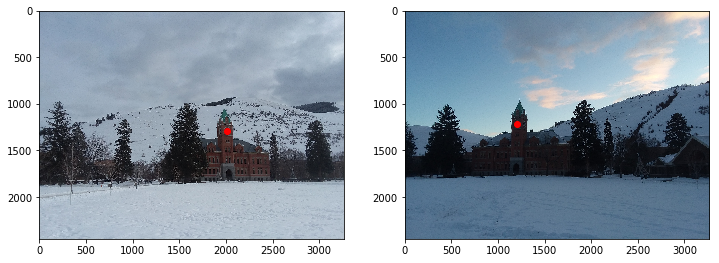

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(I_1)
ax[0].plot(*u_gcp_ct_1, 'ro')
ax[1].imshow(I_2)
ax[1].plot(*u_gcp_ct_2, 'ro')
plt.show()